In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
from scipy.stats import norm, skew
import seaborn as sns
import matplotlib
import datetime
from scipy import stats
from scipy.stats import norm, skew
from sklearn import preprocessing
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor, plot_importance
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from category_encoders import TargetEncoder, OrdinalEncoder
from sklearn.model_selection import cross_val_score
import shap
from sklearn.metrics import accuracy_score

In [ ]:
#df 불러오기
df = pd.read_csv("C://Users/cms/Downloads/csv/train.csv.zip")
df_test = pd.read_csv("C://Users/cms/Downloads/csv/test.csv.zip")
df.shape, df_test.shape

((137, 43), (100000, 42))

In [ ]:
df.head(10)

Id   Open Date            City  City Group Type  P1   P2   P3   P4  P5  \
0   0  07/17/1999        İstanbul  Big Cities   IL   4  5.0  4.0  4.0   2   
1   1  02/14/2008          Ankara  Big Cities   FC   4  5.0  4.0  4.0   1   
2   2  03/09/2013      Diyarbakır       Other   IL   2  4.0  2.0  5.0   2   
3   3  02/02/2012           Tokat       Other   IL   6  4.5  6.0  6.0   4   
4   4  05/09/2009       Gaziantep       Other   IL   3  4.0  3.0  4.0   2   
5   5  02/12/2010          Ankara  Big Cities   FC   6  6.0  4.5  7.5   8   
6   6  10/11/2010        İstanbul  Big Cities   IL   2  3.0  4.0  4.0   1   
7   7  06/21/2011        İstanbul  Big Cities   IL   4  5.0  4.0  5.0   2   
8   8  08/28/2010  Afyonkarahisar       Other   IL   1  1.0  4.0  4.0   1   
9   9  11/16/2011          Edirne       Other   IL   6  4.5  6.0  7.5   6   

   ...  P29  P30  P31  P32  P33  P34  P35  P36  P37    revenue  
0  ...  3.0    5    3    4    5    5    4    3    4  5653753.0  
1  ...  3.0    0    0    0    0    0    0    0    0  6923131.0  
2  ...  3.0    0    0    0    0    0    0    0    0  2055379.0  
3  ...  7.5   25   12   10    6   18   12   12    6  2675511.0  
4  ...  3.0    5    1    3    2    3    4    3    3  4316715.0  
5  ...  5.0    0    0    0    0    0    0    0    0  5017319.0  
6  ...  3.0    4    5    2    2    3    5    4    4  5166635.0  
7  ...  2.0    0    0    0    0    0    0    0    0  4491607.0  
8  ...  3.0    4    5    5    3    4    5    4    5  4952497.0  
9  ...  2.5    0    0    0    0    0    0    0    0  5444227.0  

[10 rows x 43 columns]

In [ ]:
df.isnull().sum()

Id            0
Open Date     0
City          0
City Group    0
Type          0
P1            0
P2            0
P3            0
P4            0
P5            0
P6            0
P7            0
P8            0
P9            0
P10           0
P11           0
P12           0
P13           0
P14           0
P15           0
P16           0
P17           0
P18           0
P19           0
P20           0
P21           0
P22           0
P23           0
P24           0
P25           0
P26           0
P27           0
P28           0
P29           0
P30           0
P31           0
P32           0
P33           0
P34           0
P35           0
P36           0
P37           0
revenue       0
dtype: int64

In [ ]:
#데이터 프로파일링
profile = ProfileReport(df, minimal=True).to_notebook_iframe()

Summarize dataset:   0%|          | 0/51 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
profile2 = ProfileReport(df_test, minimal=True).to_notebook_iframe()

Summarize dataset:   0%|          | 0/50 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

필드 데이터는 아래와 같습니다
- Id : Restaurant id. 


- Open Date : opening date for a restaurant


- City : City that the restaurant is in. Note that there are unicode in the names. 


- City Group: Type of the city. Big cities, or Other. 


- Type: Type of the restaurant. FC: Food Court, IL: Inline, DT: Drive Thru, MB: Mobile


- P1, P2 - P37: There are three categories of these obfuscated data. Demographic data are gathered from third party providers with GIS systems. These include population in any given area, age and gender distribution, development scales. Real estate data mainly relate to the m2 of the location, front facade of the location, car park availability. Commercial data mainly include the existence of points of interest including schools, banks, other QSR operators.


- Revenue: The revenue column indicates a (transformed) revenue of the restaurant in a given year and is the target of predictive analysis. Please note that the values are transformed so they don't mean real dollar values. 

In [ ]:
# type value 조정( DT와 MB 통합)
df_test.loc[df_test['Type']=='MB', 'Type'] = 'DT'

In [ ]:
df.drop('Id',axis=1,inplace=True)
df['Open Date']  = pd.to_datetime(df['Open Date'])
df_test['Open Date']  = pd.to_datetime(df_test['Open Date'])
launch_date = datetime.datetime(2015, 3, 23)
# scale days open
df['Days Open'] = (launch_date - df['Open Date']).dt.days / 1000
df_test['Days Open'] = (launch_date - df_test['Open Date']).dt.days / 1000
df.drop('Open Date', axis=1, inplace=True)
df_test.drop('Open Date', axis=1, inplace=True)

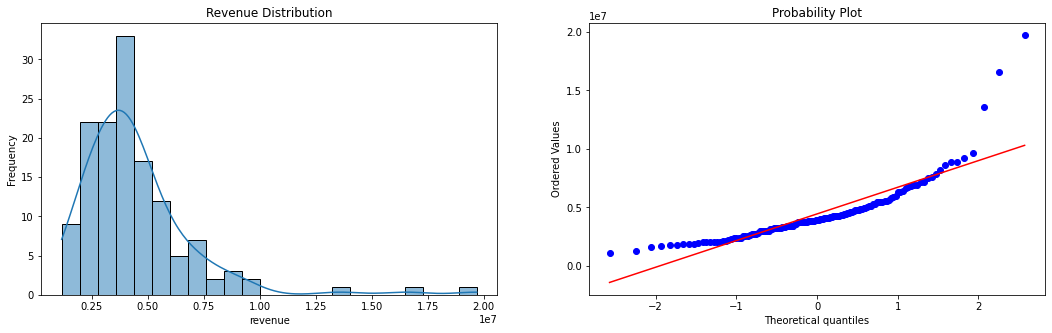

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))
ax1 = sns.histplot(df['revenue'] , ax=ax1, kde=True, legend=True, common_norm=True)
ax1.set(ylabel='Frequency', title='Revenue Distribution')
ax2 = stats.probplot(df['revenue'], plot=plt)

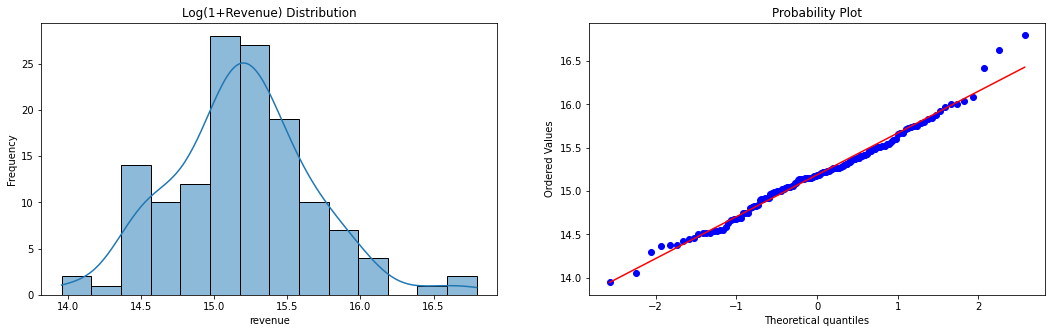

In [ ]:
# skewed 해소를 위해 logplot
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))
ax1 = sns.histplot(np.log1p(df['revenue']) , ax=ax1, kde=True, legend=True, common_norm=True)
ax1.set(ylabel='Frequency', title='Log(1+Revenue) Distribution')
ax2 = stats.probplot(np.log(df['revenue']), plot=plt)

In [ ]:
# 1.00 le7 이상의 outlier 통제
df.loc[df['revenue'] > 10000000, 'revenue'] = 10000000

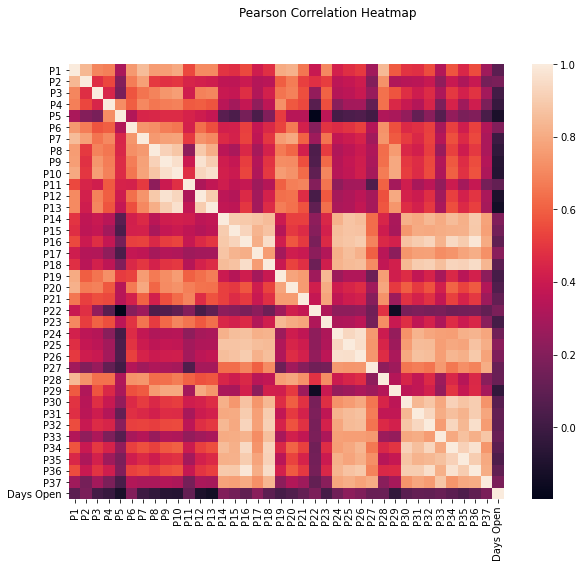

In [ ]:
# Correlation between numeric features with revenue
plt.figure(figsize=(10, 8))
sns.heatmap(df.drop(['City', 'revenue','City Group','Type'], axis=1).corr(), square=True)
plt.suptitle('Pearson Correlation Heatmap')
plt.show();

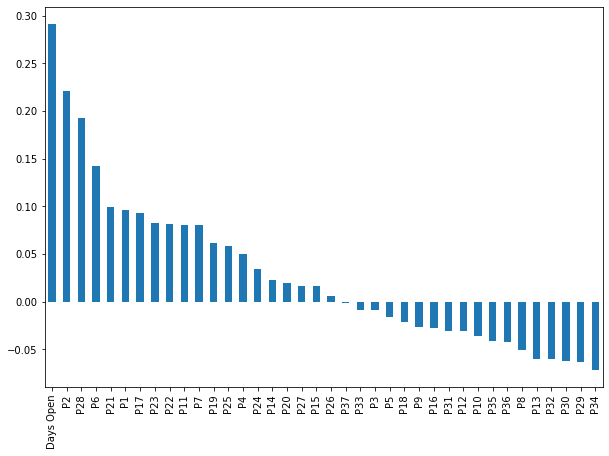

In [ ]:
corr_with_revenue = df.drop(['City Group','Type'],axis=1).corr()['revenue'].sort_values(ascending=False)
plt.figure(figsize=(10,7))
corr_with_revenue.drop('revenue').plot.bar()
plt.show();

In [ ]:
# 분포 오른쪽으로 밀어주기
df['revenue'] = np.log1p(df['revenue'])
#target 분리 및 train test set 나누기
X, y = df.drop('revenue', axis=1), df['revenue']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=118)

In [ ]:
# pipeline 가동
encoding_model = make_pipeline(
    OrdinalEncoder(cols=('City Group', 'Type')),
    TargetEncoder(cols=('City', 'City Group', 'Type')),
    IterativeImputer(max_iter=30, missing_values=0, sample_posterior=True, min_value=1, random_state=23),
)

X_train = encoding_model.fit_transform(X_train, y_train)
X_test = encoding_model.fit_transform(X_test, y_test)

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


In [ ]:
X_train = pd.DataFrame(X_train, columns=df.drop('revenue', axis=1).columns)
X_test = pd.DataFrame(X_test, columns=df.drop('revenue', axis=1).columns)
X_test

City  City Group       Type    P1   P2        P3   P4   P5   P6  \
0   15.211400   14.990726  15.014714   4.0  5.0  2.000000  5.0  2.0  2.0   
1   14.853756   14.990726  15.014714   1.0  2.0  5.000000  4.0  1.0  2.0   
2   14.819706   15.250172  15.014714   3.0  5.0  3.000000  5.0  3.0  4.0   
3   15.111183   14.990726  15.014714   2.0  2.0  4.000000  3.0  1.0  1.0   
4   15.211400   14.990726  15.014714   4.0  5.0  2.000000  4.0  2.0  2.0   
5   15.447828   15.250172  15.014714   5.0  5.0  4.000000  4.0  1.0  3.0   
6   14.853756   14.990726  15.014714   2.0  3.0  4.000000  3.0  1.0  4.0   
7   14.819706   15.250172  15.014714   3.0  5.0  5.000000  3.0  1.0  5.0   
8   15.111183   14.990726  15.299396   3.0  4.0  3.000000  4.0  2.0  2.0   
9   15.111183   14.990726  15.014714   3.0  4.0  4.000000  4.0  2.0  2.0   
10  15.447828   15.250172  15.299396   6.0  4.5  6.000000  6.0  4.0  8.0   
11  15.447828   15.250172  15.299396  12.0  7.5  6.000000  6.0  4.0  4.0   
12  15.447828   15.250172  15.014714   3.0  5.0  4.000000  4.0  2.0  5.0   
13  15.111183   14.990726  15.014714   2.0  4.0  4.000000  4.0  1.0  2.0   
14  15.111183   14.990726  15.014714   2.0  2.0  4.000000  4.0  3.0  1.0   
15  15.447828   15.250172  15.014714   4.0  5.0  4.000000  4.0  1.0  3.0   
16  14.819706   15.250172  15.014714   2.0  4.0  4.000000  4.0  1.0  2.0   
17  15.111183   14.990726  15.299396   4.0  5.0  5.000000  4.0  2.0  2.0   
18  15.111183   14.990726  15.014714   2.0  4.0  4.000000  4.0  2.0  2.0   
19  15.447828   15.250172  15.014714   4.0  5.0  4.000000  4.0  1.0  3.0   
20  15.447828   15.250172  15.299396   2.0  4.0  4.000000  4.0  2.0  5.0   
21  15.111183   14.990726  15.299396   3.0  3.0  4.000000  4.0  2.0  2.0   
22  15.447828   15.250172  15.014714   3.0  4.0  4.000000  5.0  2.0  2.0   
23  15.111183   14.990726  15.299396   4.0  5.0  4.000000  3.0  1.0  3.0   
24  15.447828   15.250172  15.299396  12.0  7.5  6.000000  6.0  2.0  8.0   
25  15.111183   14.990726  15.299396   2.0  4.0  4.000000  4.0  2.0  2.0   
26  15.111183   14.990726  15.014714   3.0  4.0  3.000000  4.0  3.0  2.0   
27  14.819706   15.250172  15.111183   1.0  3.0  5.623001  5.0  5.0  5.0   

      P7  ...  P29        P30        P31        P32       P33        P34  \
0    5.0  ...  3.0  12.418579   5.661449   7.713155  3.909536   4.858015   
1    1.0  ...  2.0   5.566960   3.455384   6.922312  2.825403   3.257534   
2    5.0  ...  2.0   7.007076   3.206525   5.091737  1.772441   4.172338   
3    1.0  ...  3.0  12.566105   1.896405   4.614111  2.136563   4.762891   
4    5.0  ...  2.0   4.985226   5.638629   7.599678  3.569339   4.691221   
5    5.0  ...  2.0  16.836757   5.975096  21.128041  2.633109  11.558817   
6    5.0  ...  2.0   1.744637   1.860580   3.929174  2.448358   2.121485   
7    5.0  ...  3.0   7.268004   4.337865   2.504552  1.109758   5.142255   
8    5.0  ...  3.0   5.000000   1.000000   3.000000  2.000000   3.000000   
9    5.0  ...  3.0   9.990261   5.774457   6.047513  2.868949   5.290273   
10  10.0  ...  7.5  25.000000  15.000000  25.000000  4.000000  18.000000   
11  10.0  ...  5.0  26.890780   9.761886  14.789787  5.365612  13.073066   
12   5.0  ...  2.0  14.443690   6.406823  11.229537  2.743214   8.735968   
13   5.0  ...  2.0  14.675723   4.527363   9.798819  3.202978   6.881792   
14   4.0  ...  3.0   6.161437   4.148104  11.140149  3.803345   4.644511   
15   5.0  ...  3.0  13.339447   6.735806  14.640015  3.283051   8.126438   
16   5.0  ...  2.0   2.863622   5.277877   5.575502  1.720880   3.607389   
17   5.0  ...  1.0   5.000000   3.000000   3.000000  2.000000   3.000000   
18   5.0  ...  3.0  12.413636  10.341494   8.447069  3.131690   6.935151   
19   5.0  ...  3.0   5.805045  13.280836  16.645773  5.194278   6.033766   
20   5.0  ...  3.0   5.000000   5.000000   4.000000  2.000000   3.000000   
21   5.0  ...  3.0   5.000000   5.000000   5.000000  4.000000   2.000000   
22   5.0  ...  3.0  19.492088   9.681894  19.569705  4.9

In [ ]:
# base model
base_model = LinearRegression()
base_model.fit(X_train, y_train)
y_train_pred = base_model.predict(X_train)
y_pred = base_model.predict(X_test)
print('Train r2 score: ', r2_score(y_train_pred, y_train))
print('Test r2 score: ', r2_score(y_test, y_pred))
train_rmse = np.sqrt(mean_squared_error(y_train_pred, y_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Train RMSE: {train_rmse:.4f}')
print(f'Test RMSE: {test_rmse:.4f}')

Train r2 score:  -0.063886930506178
Test r2 score:  0.3033002391808557
Train RMSE: 0.3147
Test RMSE: 0.4096


In [ ]:
#ridge model 
params_ridge = {
    'alpha' : [.01, .1, .5, .7, .9, .95, .99, 1, 5, 10, 20],
    'fit_intercept' : [True, False],
    'normalize' : [True,False],
    'solver' : ['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
}
ridge_model = Ridge()

In [ ]:
ridge_regressor = GridSearchCV(ridge_model, params_ridge, scoring='neg_root_mean_squared_error', cv=5, n_jobs=-1)
ridge_regressor.fit(X_train, y_train)
print(f'Optimal alpha: {ridge_regressor.best_params_["alpha"]:.2f}')
print(f'Optimal fit_intercept: {ridge_regressor.best_params_["fit_intercept"]}')
print(f'Optimal normalize: {ridge_regressor.best_params_["normalize"]}')
print(f'Optimal solver: {ridge_regressor.best_params_["solver"]}')
print(f'Best score: {ridge_regressor.best_score_}')

Optimal alpha: 0.70
Optimal fit_intercept: True
Optimal normalize: True
Optimal solver: lsqr
Best score: -0.4072782135311722


In [ ]:
ridge_model =Ridge(alpha=ridge_regressor.best_params_["alpha"], 
                    fit_intercept=ridge_regressor.best_params_["fit_intercept"], 
                    normalize=ridge_regressor.best_params_["normalize"], 
                    solver=ridge_regressor.best_params_["solver"]
                   )
ridge_model.fit(X_train, y_train)
y_train_pred = ridge_model.predict(X_train)
y_pred = ridge_model.predict(X_test)
print('Train r2 score: ', r2_score(y_train_pred, y_train))
print('Test r2 score: ', r2_score(y_test, y_pred))
train_rmse = np.sqrt(mean_squared_error(y_train_pred, y_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Train RMSE: {train_rmse:.4f}')
print(f'Test RMSE: {test_rmse:.4f}')

Train r2 score:  -3.806182877977405
Test r2 score:  0.3427088826516673
Train RMSE: 0.3593
Test RMSE: 0.3979


In [ ]:
# 3-fold 교차검증을 수행합니다.
k = 3
scores = cross_val_score(ridge_model, X_train, y_train, cv=k, 
                         scoring='neg_mean_absolute_error')

print(f'MAE ({k} folds):', -scores)

MAE (3 folds): [0.33863138 0.33380184 0.28701475]


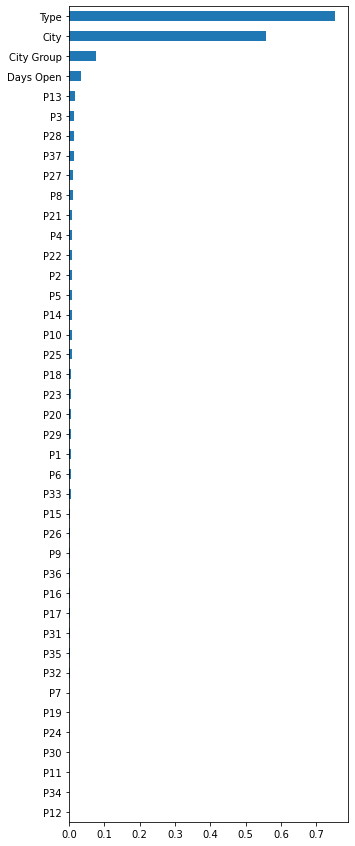

In [ ]:
# Ridge Model Feature Importance
ridge_feature_coef = pd.Series(index = X_train.columns, data = np.abs(ridge_model.coef_))
ridge_feature_coef.sort_values().plot(kind = 'barh', figsize = (5,15));

In [ ]:
#RandomForest

params_rf = {
    'max_depth': [10, 30, 35, 50, 65, 75, 100],
    'max_features': [.3, .4, .5, .6],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [30, 50, 100, 200]
}

rf =RandomForestRegressor()

In [ ]:
rf_regressor = GridSearchCV(rf, params_rf, scoring='neg_root_mean_squared_error', cv = 10, n_jobs = -1)
rf_regressor.fit(X_train, y_train)
print(f'Optimal depth: {rf_regressor.best_params_["max_depth"]}')
print(f'Optimal max_features: {rf_regressor.best_params_["max_features"]}')
print(f'Optimal min_sample_leaf: {rf_regressor.best_params_["min_samples_leaf"]}')
print(f'Optimal min_samples_split: {rf_regressor.best_params_["min_samples_split"]}')
print(f'Optimal n_estimators: {rf_regressor.best_params_["n_estimators"]}')
print(f'Best score: {rf_regressor.best_score_}')

Optimal depth: 50
Optimal max_features: 0.6
Optimal min_sample_leaf: 3
Optimal min_samples_split: 8
Optimal n_estimators: 30
Best score: -0.37556028917029616


In [ ]:
rf_model = RandomForestRegressor(max_depth=rf_regressor.best_params_["max_depth"], 
                                 max_features=rf_regressor.best_params_["max_features"], 
                                 min_samples_leaf=rf_regressor.best_params_["min_samples_leaf"], 
                                 min_samples_split=rf_regressor.best_params_["min_samples_split"], 
                                 n_estimators=rf_regressor.best_params_["n_estimators"], 
                                 n_jobs=-1, oob_score=True)
rf_model.fit(X_train, y_train)
y_train_pred = rf_model.predict(X_train)
y_pred = rf_model.predict(X_test)
print('Train r2 score: ', r2_score(y_train_pred, y_train))
print('Test r2 score: ', r2_score(y_test, y_pred))
train_rmse = np.sqrt(mean_squared_error(y_train_pred, y_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Train RMSE: {train_rmse:.4f}')
print(f'Test RMSE: {test_rmse:.4f}')

Train r2 score:  0.3612961671447156
Test r2 score:  0.280618419934373
Train RMSE: 0.2184
Test RMSE: 0.4163


In [ ]:
# 3-fold 교차검증을 수행합니다.
k = 3
scores = cross_val_score(rf_model, X_train, y_train, cv=k, 
                         scoring='neg_mean_absolute_error')

print(f'MAE ({k} folds):', -scores)

MAE (3 folds): [0.34275204 0.35269893 0.2668612 ]


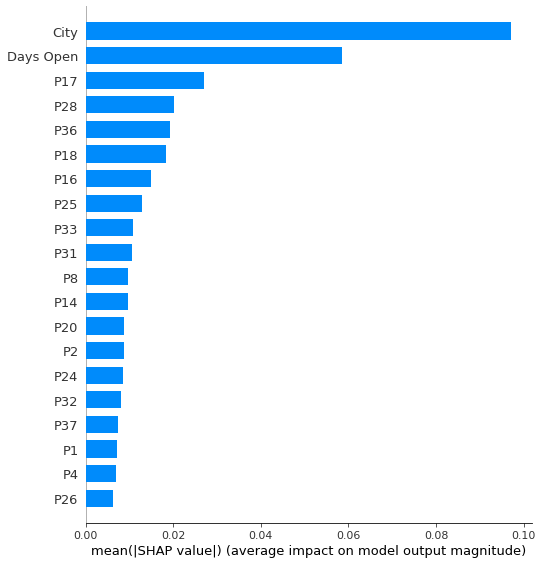

In [ ]:
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type='bar')

In [ ]:
#XGBoost
params_xgb = {
    'learning_rate': [.1, .5, .7, .9, .95, .99, 1],
    'colsample_bytree': [.3, .4, .5, .6],
    'n_estimators': [30, 70, 100, 200]
}

xgb_model = XGBRegressor(max_depth=4, alpha=3, subsample=0.5)

In [ ]:
xgb_regressor = GridSearchCV(xgb_model, params_xgb, scoring='neg_root_mean_squared_error', cv = 10, n_jobs = -1)
xgb_regressor.fit(X_train, y_train)
print(f'Optimal lr: {xgb_regressor.best_params_["learning_rate"]}')
print(f'Optimal colsample_bytree: {xgb_regressor.best_params_["colsample_bytree"]}')
print(f'Optimal n_estimators: {xgb_regressor.best_params_["n_estimators"]}')
print(f'Best score: {xgb_regressor.best_score_}')

Optimal lr: 0.1
Optimal colsample_bytree: 0.4
Optimal n_estimators: 200
Best score: -0.39871198307977174


In [ ]:
xgb_model = XGBRegressor(learning_rate=xgb_regressor.best_params_["learning_rate"], 
                         colsample_bytree=xgb_regressor.best_params_["colsample_bytree"], 
                         max_depth=4, alpha=3, subsample=.5, 
                         n_estimators=xgb_regressor.best_params_["n_estimators"], n_jobs=-1)
xgb_model.fit(X_train, y_train)
y_train_pred = xgb_model.predict(X_train)
y_pred = xgb_model.predict(X_test)
print('Train r2 score: ', r2_score(y_train_pred, y_train))
print('Test r2 score: ', r2_score(y_test, y_pred))
train_rmse = np.sqrt(mean_squared_error(y_train_pred, y_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Train RMSE: {train_rmse:.4f}')
print(f'Test RMSE: {test_rmse:.4f}')

Train r2 score:  -0.04577505054174558
Test r2 score:  0.3744732971835012
Train RMSE: 0.2529
Test RMSE: 0.3882


In [ ]:
# 3-fold 교차검증을 수행합니다.
k = 3
scores = cross_val_score(xgb_model, X_train, y_train, cv=k, 
                         scoring='neg_mean_absolute_error')

print(f'MAE ({k} folds):', -scores)

MAE (3 folds): [0.36921501 0.33385725 0.28634049]


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


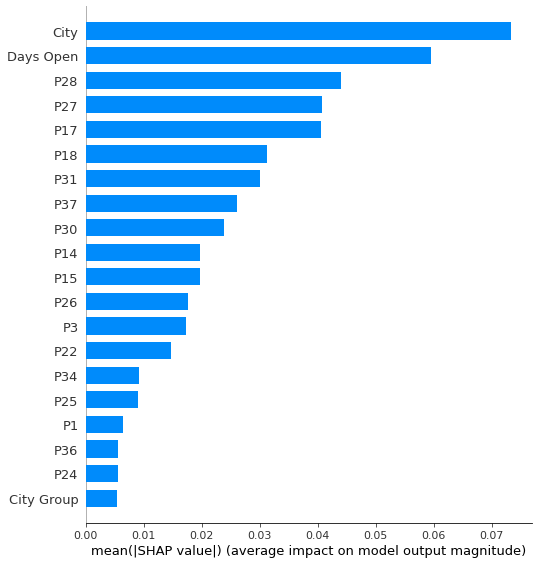

In [ ]:
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type='bar')